# Image Classification using convolutional layers
In this notebook, a Convolutional Neural Network will be build from scratch and trained on the MNIST dataset. The MNIST dataset is a dataset containing hand-written images of digits. The end goal is to label the images with their corresponding digit. Take a look at the Feedforward Neural Network Image Classification of the MNIST dataset for the exploring of the MNIST dataset and the explanation about the data preparation.    

In [1]:
# Imports
import copy
import torch
import random
import numpy as np
import torch.nn as nn 
from torch.optim import SGD 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
from torchmetrics.classification import MulticlassAccuracy 
from torch.utils.data import Dataset, DataLoader, random_split

c:\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\python39\lib\site-packages\torchaudio\backend\utils.py:66: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


## Creating the dataset class
In this part, a class will be created for the datasets. This class will contain Python functions such as length of the dataset and get the specific item (=slicing) from the dataset.

In [2]:
class Custom_Dataset(Dataset):

    def __init__(self, data):

        # The data is split into images and labels
        self.x, self.y = data

        # The pixel values are converted to doubles
        self.x = self.x/ 255.

        # The labels are encoded 
        self.y = F.one_hot(self.y, num_classes=10).to(float)

    # This function can always return the size of the dataset
    def __len__(self):
        return self.x.shape[0]

    # This function can always retrieve an item from the dataset
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

In [3]:
# Define transforms that will be applied to the downloaded images
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

# Load MNIST training and test dataset
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=False, transform=transform)
mnist_testset = datasets.MNIST(root='../../data', train=False, download=False, transform=transform)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)
valid_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

# Create a total dataloader dictionary
dataloaders = {'train': train_loader, 'valid': valid_loader}

## Creating the neural network model class
In this section, a definition of the Neural Network will be created. In this example, two convolutional layers followed by a ReLU non-linearity and average pooling are the first part of the Convolutional Neural Network. The last part is the flattening of the feature maps followed by the linear layers.

In [4]:
class NeuralNet(nn.Module):

    def __init__(self):
        super().__init__()

        # Convolutional layer where the input image will be converted to 16 feature maps
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=1, padding=2),
            nn.ReLU(), # ReLU activation
            nn.AvgPool2d(2, stride=2) # Average pooling layer
        )

        # Convolutional layer where the previous 16 feature maps will be converted to 32 feature maps
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32 , 5, stride=1, padding=2),
            nn.ReLU(), # ReLU activation
            nn.AvgPool2d(2, stride=2) # Average pooling layer
        )

        # Output layer where the 32 feature maps get flattened to a vector of 10
        self.out = nn.Linear(32*7*7,10)

    # This function executs the forward pass of an image x to the neural net
    def forward(self,x):
        x = self.conv1(x) # Passing the input image through the first convolutional layer
        x = self.conv2(x) # Passing the resulting feature maps through the second convolutional layer
        x = x.view(x.size(0),-1) # The output of the last convolutional layer is flattened (batch size, 32x7x7)
        x = self.out(x)
        return x

# Create the neural net object
model = NeuralNet()

## Model training
A function is created to automise the training of the Convolutional Neural Network.

In [5]:
# Search for the available training device on the computer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def train_model(model, optimizer, criterum, n_epochs=20):

    # Learning curves
    results = {"training_acc": [], "training_loss": [], "validation_acc": [], "validation_loss": []}

    # Loop over all epochs
    best_loss = float('inf')
    for epoch in range(n_epochs):

        # Debug
        print('Epoch {}/{}'.format(epoch+1, n_epochs))
        print('-'*10)

        # Each epoch has a training and validation phase
        for phase in ['train','valid']:

            # Set the network state dependent on the phase
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Reset the losses and corrects at the start of each epoch
            running_loss = 0.0
            running_corrects = 0.0

            # Extract batches from the data loaders untill all batches are retrieved
            num_samples = 0
            for inputs, labels in dataloaders[phase]:

                # Inputs shape
                batch_size, c, h, w = inputs.shape

                # Store the inputs and labels to the selected device
                inputs = inputs.to(device)  
                labels = labels.to(device)  

                # Forward pass through the network
                outputs = model(inputs)

                # Softmax transforms the output probabilities into one selected class
                _, class_pred = torch.max(outputs, 1)

                # Compute the loss of the batch
                loss = criterium(outputs, labels)
                
                # Update the losses and corrects for this batch
                running_loss += loss.item() * batch_size
                running_corrects += class_pred.eq(labels).sum().item()

                # Calculate total samples
                num_samples += batch_size

                # If in training phase, adapt the model paramters to account for the losses
                if phase=='train':
                    optimizer.zero_grad() # Pytorch keeps track of the gradients over multiple epochs, therefore initialise it to 0
                    loss.backward() # Calculate the weight gradients (Backward Propagation)
                    optimizer.step() # Update the model parameters using the defined optimizer 
                    
            # Save results
            if phase == 'train':
                results['training_acc'].append((running_corrects/num_samples)*100)
                results['training_loss'].append(running_loss/num_samples)
                print("train_acc %.3f train_loss %.3f" % (running_corrects/num_samples, running_loss/num_samples))
            elif phase == 'valid':
                results['validation_acc'].append((running_corrects/num_samples)*100)
                results['validation_loss'].append(running_loss/num_samples)
                print("val_acc %.3f val_loss %.3f" % (running_corrects/num_samples, running_loss/num_samples))

        # Save model
        if loss < best_loss:
            torch.save(model, '../../models/classification_model.pt')
            best_loss = loss

    return results


In [7]:
# Set the optimizer
optimizer = SGD(model.parameters(), lr=0.001)
criterium = nn.CrossEntropyLoss()

# Train for 50 epochs
results = train_model(model, optimizer, criterium, n_epochs=10)

Epoch 1/10
----------


train_acc 0.692 train_loss 1.045


val_acc 0.882 val_loss 0.385
Epoch 2/10
----------


train_acc 0.891 train_loss 0.361


val_acc 0.909 val_loss 0.304
Epoch 3/10
----------


train_acc 0.914 train_loss 0.284


val_acc 0.929 val_loss 0.244
Epoch 4/10
----------


train_acc 0.932 train_loss 0.230


val_acc 0.940 val_loss 0.194
Epoch 5/10
----------


train_acc 0.943 train_loss 0.191


val_acc 0.951 val_loss 0.165
Epoch 6/10
----------


train_acc 0.951 train_loss 0.163


val_acc 0.958 val_loss 0.145
Epoch 7/10
----------


train_acc 0.957 train_loss 0.143


val_acc 0.962 val_loss 0.122
Epoch 8/10
----------


train_acc 0.962 train_loss 0.127


val_acc 0.967 val_loss 0.109
Epoch 9/10
----------


train_acc 0.966 train_loss 0.115


val_acc 0.970 val_loss 0.097
Epoch 10/10
----------


train_acc 0.968 train_loss 0.106


val_acc 0.972 val_loss 0.093


The loss function is plotted for each epoch during the training procedure.

Text(0.5, 1.0, 'Accuracy')

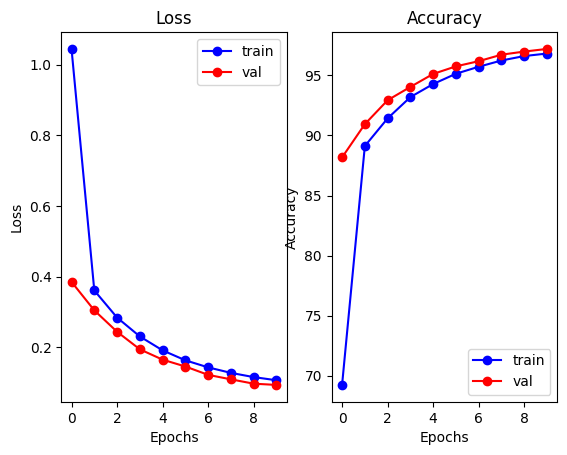

In [8]:
# Plot results
plt.subplot(1, 2, 1)
plt.plot(range(len(results['training_loss'])), results['training_loss'], 'bo-', label='train')
plt.plot(range(len(results['validation_loss'])), results['validation_loss'], 'ro-', label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(len(results['training_acc'])), results['training_acc'], 'bo-', label='train')
plt.plot(range(len(results['validation_acc'])), results['validation_acc'], 'ro-', label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')

The loss is already very low from the first epoch. The validation loss also starts to rise again after a certain amount of epochs. This is because overfitting of the model on the training set is occurring. Therefore, the weights of the model with the best validation accuracy are stored.

## Model validation

To validate the model we can compare the predicted value of an image to the ground thruth. We can do this for the first batch. 

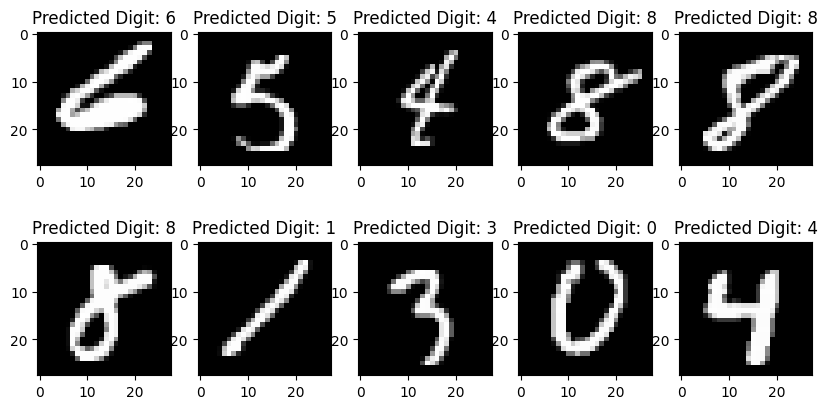

In [9]:
# Extract a batch
batch = next(iter(train_loader))

# Extract the images and labels
x, y = batch

# Get the predictions for the whole batch
y_pred = model(x).argmax(axis=1)

# Plot predictions and labels
fig, ax = plt.subplots(2,5,figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x[i].permute(1,2,0), cmap='gray')
    plt.title(f'Predicted Digit: {y_pred[i]}')
plt.show()

In [10]:
# Reset the losses and corrects at the start of each epoch
running_corrects = 0.0

# Extract batches from the data loaders untill all batches are retrieved
num_samples = 0
for inputs, labels in valid_loader:

    # Inputs shape
    batch_size, c, h, w = inputs.shape

    # Store the inputs and labels to the selected device
    inputs = inputs.to(device)  
    labels = labels.to(device)  

    # Forward pass through the network
    outputs = model(inputs)

    # Softmax transforms the output probabilities into one selected class
    _, class_pred = torch.max(outputs, 1)
    
    # Update the losses and corrects for this batch
    running_corrects += class_pred.eq(labels).sum().item()

    # Calculate total samples
    num_samples += batch_size

# Print results
print('The model has an accuracy of ' + str((running_corrects/num_samples)*100) + ' on the validation set.')

The model has an accuracy of 97.2 on the validation set.
